In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import DataLoader, TensorDataset

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [3]:
from sklearn.datasets import fetch_openml
mnist_org = fetch_openml('mnist_784', version=1, as_frame=False, parser='auto')

In [4]:
mnist_org.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [5]:
data = mnist_org.data
data

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [6]:
targets = mnist_org.target
targets

array(['5', '0', '4', ..., '4', '5', '6'], dtype=object)

In [7]:
print(data.min())
print(data.max())

0
255


In [8]:
# Scale the data using minmax scaler to a range of 0 to -1
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
data = scaler.fit_transform(data)
data

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [9]:
data.dtype

dtype('float64')

In [10]:
data.shape

(70000, 784)

In [11]:
data = data.reshape((70000, 1, 28, 28))
data.shape

(70000, 1, 28, 28)

In [12]:
# Convert data to pytorch tensors
dataT = torch.tensor(data).float()

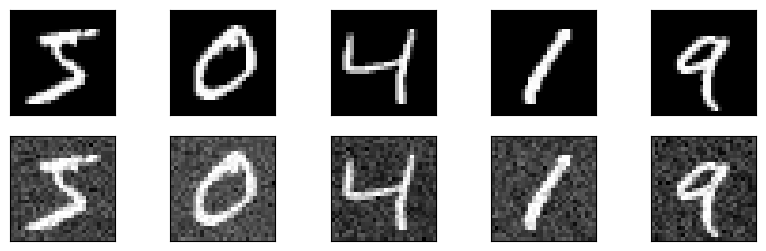

In [13]:
noise = torch.randn_like(dataT)*0.1 + 0  # std = 0.1 and mean = 0
noisy_dataT = dataT + noise

noisy_dataT[noisy_dataT > 1] = 1

# Show the noisy images
fig, axs = plt.subplots(2, 5, figsize=(10, 3))

for i in range(5):
    axs[0, i].imshow(dataT[i, :].view(28,28), cmap='gray')
    axs[1, i].imshow(noisy_dataT[i, :].view(28, 28), cmap='gray')
    axs[0, i].set_xticks([]), axs[0, i].set_yticks([])
    axs[1, i].set_xticks([]), axs[1, i].set_yticks([])
plt.show()

In [14]:
# Convert to TensorDatasets
train_data = TensorDataset(noisy_dataT, dataT)

# Translate to dataloader objects
batchsize = 128
data_loader = DataLoader(train_data, batch_size=batchsize, shuffle=True, drop_last=True)

In [15]:
def create_autoencoder():

    class ConvolutionalAutoencoder(nn.Module):
        def __init__(self):
            super().__init__()

            """
            Encoder block
            --------------
            Input padding -> Convolution -> Max Pooling.

            """
            self.conv1 = nn.Conv2d(in_channels=1, out_channels=8, kernel_size=3, stride=1, padding=1)
            self.bnorm1 = nn.BatchNorm2d(8)
            # Output size after pooling: np.floor((28+2*1-3)/1)+1 = 28/2 = 14

            self.conv2 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, stride=1, padding=2)
            self.bnorm2 = nn.BatchNorm2d(16)
            # Output size after pooling: np.floor((14+2*2-3)/1)+1 = 16/2 = 8

            self.conv3 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
            self.bnorm3 = nn.BatchNorm2d(32)
            # Output size after pooling: np.floor((8+2*1-3)/1)+1 = 8/2 = 4


            """
            Decoder block
            --------------
            """
            self.t_conv1 = nn.ConvTranspose2d(in_channels=32, out_channels=16, kernel_size=3, stride=1, padding=1)
            self.t_bnorm1 = nn.BatchNorm2d(16)
            # Input image size: 4
            # Size after MaxUnpooling: 4*2 = 8
            # Size after transpose convolution and output padding: (8-1)*1 - 2*1 + 1*(3-1) + 0 + 1 = 8

            self.t_conv2 = nn.ConvTranspose2d(in_channels=16, out_channels=8, kernel_size=3, stride=1, padding=2)
            self.t_bnorm2 = nn.BatchNorm2d(8)
            # Input image size: 8
            # Size after MaxUnpooling: 8*2 = 16
            # Size after transpose convolution and output padding: (16-1)*1 - 2*2 + 1*(3-1) + 0 + 1 = 14

            self.t_conv3 = nn.ConvTranspose2d(in_channels=8, out_channels=1, kernel_size=3, stride=1, padding=1)
            self.t_bnorm3 = nn.BatchNorm2d(1)
            # Input image size: 14
            # Size after MaxUnpooling: 14*2 = 28
            # Size after transpose convolution and output padding: (28-1)*1 - 2*1 + 1*(3-1) + 0 + 1 = 28

        def __call__(self, X):
            X, i1, i2, i3 = self.encoder(X)
            yHat = self.decoder(X, i3, i2, i1)
            return yHat

        def encoder(self, X):
            """
            Encoder Block
            -------------
            Convolution -> Max Pooling -> Batch Normalization -> Leaky Relu -> Dropout Regularization

            """
            # 1st layer
            X = self.conv1(X)
            X, indices_conv1 = F.max_pool2d(X, kernel_size=2, return_indices=True)
            X = self.bnorm1(X)
            X = F.relu(X)
            X = F.dropout(X, p=0.25, training=self.training)

            # 2nd layer
            X = self.conv2(X)
            X, indices_conv2 = F.max_pool2d(X, kernel_size=2, return_indices=True)
            X = self.bnorm2(X)
            X = F.relu(X)
            X = F.dropout(X , p=0.25, training=self.training)

            # 3rd layer
            X = self.conv3(X)
            X, indices_conv3 = F.max_pool2d(X, kernel_size=2, return_indices=True)
            X = self.bnorm3(X)
            X = F.relu(X)
            X = F.dropout(X, p=0.25, training=self.training)

            return X, indices_conv1, indices_conv2, indices_conv3

        def decoder(self, X, indices_conv3, indices_conv2, indices_conv1):
            """
            Decoder Block
            -------------
            Max Unpooling -> Transpose Convolution -> Batch Normalization -> Leaky Relu -> Dropout Regularization

            """
            # 1st layer
            X = F.max_unpool2d(X, indices=indices_conv3, kernel_size=2)
            X = self.t_conv1(X)
            X = self.t_bnorm1(X)
            X = F.relu(X)
            X = F.dropout(X, p=0.25, training=self.training)

            # 2nd layer
            X = F.max_unpool2d(X, indices=indices_conv2, kernel_size=2)
            X = self.t_conv2(X)
            X = self.t_bnorm2(X)
            X = F.relu(X)
            X = F.dropout(X, p=0.25, training=self.training)

            # 3rd layer
            X = F.max_unpool2d(X, indices=indices_conv1, kernel_size=2)
            X = self.t_conv3(X)
            X = self.t_bnorm3(X)
            # X = F.relu(X)
            X = F.dropout(X, p=0.25, training=self.training)

            return F.sigmoid(X)

    # Create a net
    net = ConvolutionalAutoencoder()

    # Loss function
    lossfun = nn.MSELoss()

    # Optimizer
    optimizer = torch.optim.Adam(net.parameters(), lr=0.01)

    return net, lossfun, optimizer

In [16]:
# Test this model with a bit of data
net, lossfun, optimizer = create_autoencoder()

X = dataT[:5, :]
yHat = net(X)

print(yHat.shape)
print(yHat.shape)

torch.Size([5, 1, 28, 28])
torch.Size([5, 1, 28, 28])


In [18]:
def train_autoencoder():

    # Number of epochs
    numepochs=10

    # Create a new model
    net, lossfun, optimizer = create_autoencoder()

    # Send the model to the GPU
    net.to(device)
    lossfun.to(device)

    # Initialize the losses
    losses = []

    for epoch in range(numepochs):

        net.train()

        # Initialize batch losses
        batch_losses = []

        for X, y in data_loader:

            X = X.to(device)
            y = y.to(device)

            # Forward pass
            yHat = net(X)

            # Compute loss
            loss = lossfun(yHat, y)

            # Backprop
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Loss and error from this batch
            batch_losses.append(loss.item())

        # average loss over across the batches
        losses.append(np.mean(batch_losses))
        print(f"Epoch {epoch+1}/{numepochs}")

    # Switch to eval mode.
    net.eval()

    return losses, net

In [19]:
net, lossfun, optimizer = create_autoencoder()

In [20]:
losses, net = train_autoencoder()

Epoch 1/10
Epoch 2/10
Epoch 3/10
Epoch 4/10
Epoch 5/10
Epoch 6/10
Epoch 7/10
Epoch 8/10
Epoch 9/10
Epoch 10/10


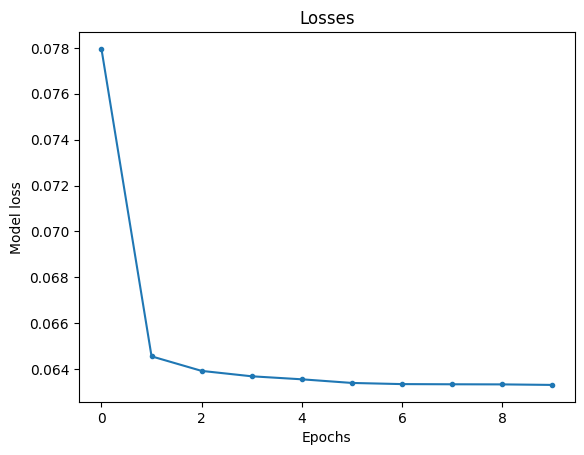

In [21]:
# Visualize the losses
plt.plot(losses, '.-')
plt.xlabel('Epochs')
plt.ylabel('Model loss')
plt.title('Losses')
plt.show()

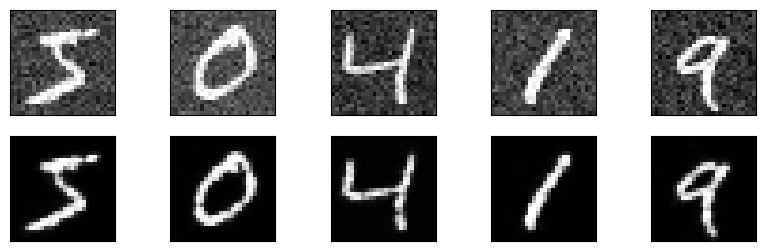

In [22]:
# Repeat the visualization when testing the model
X = noisy_dataT[:5, :]
yHat = net(X.to(device))

# Let's see what the model did!
fig, axs = plt.subplots(2, 5, figsize=(10, 3))

for i in range(5):
    axs[0, i].imshow(X[i, :].view(28, 28).detach(), cmap='gray')
    axs[1, i].imshow(yHat.cpu()[i, :].view(28, 28).detach(), cmap='gray')
    axs[0, i].set_xticks([]), axs[0, i].set_yticks([])
    axs[1, i].set_xticks([]), axs[1, i].set_yticks([])

plt.show()

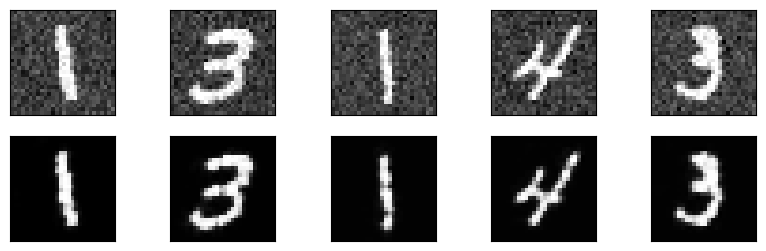

In [23]:
# Repeat the visualization when testing the model
X = noisy_dataT[6:11, :]
yHat = net(X.to(device))

# Let's see what the model did!
fig, axs = plt.subplots(2, 5, figsize=(10, 3))

for i in range(5):
    axs[0, i].imshow(X[i, :].view(28, 28).detach(), cmap='gray')
    axs[1, i].imshow(yHat.cpu()[i, :].view(28, 28).detach(), cmap='gray')
    axs[0, i].set_xticks([]), axs[0, i].set_yticks([])
    axs[1, i].set_xticks([]), axs[1, i].set_yticks([])

plt.show()

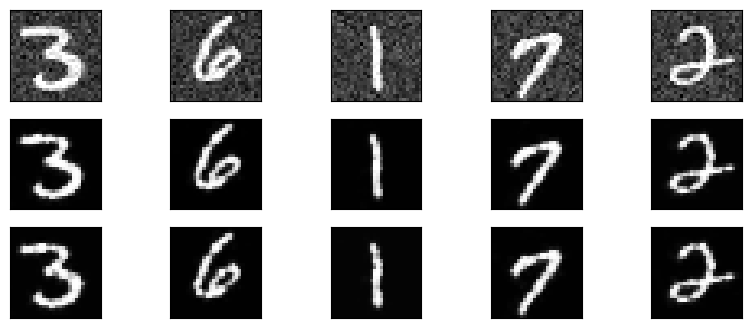

In [27]:
# Repeat the visualization when testing the model
X_noisy = noisy_dataT[12:17, :]
X = dataT[12:17, :]
yHat_noisy = net(X_noisy.to(device))
yHat = net(X.to(device))

# Let's see what the model did!
fig, axs = plt.subplots(3, 5, figsize=(10, 4))

for i in range(5):
    axs[0, i].imshow(X_noisy[i, :].view(28, 28).detach(), cmap='gray')
    axs[1, i].imshow(yHat.cpu()[i, :].view(28, 28).detach(), cmap='gray')
    axs[2, i].imshow(yHat_noisy.cpu()[i, :].view(28, 28).detach(), cmap='gray')
    axs[0, i].set_xticks([]), axs[0, i].set_yticks([])
    axs[1, i].set_xticks([]), axs[1, i].set_yticks([])
    axs[2, i].set_xticks([]), axs[2, i].set_yticks([])

plt.show()